# Initial tests to run DEM validation

In [1]:
import rasterio 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

In [2]:
#jupyter magic
%matplotlib notebook


In [3]:
#path to DEM
demfile = 'C:\\jlogan_python\\demValidation\\data\\2017-1101-LPD_UAS-SfM-DEM_10cm.tif'

#path to check points csv:
checkfile = 'C:\\jlogan_python\\demValidation\\data\\2017-1101-LPD-UAS_backpackTopoValidation.csv'

In [4]:
#load DEM (geotiff)
dataset = rasterio.open(demfile)

#get numpy array
dem = dataset.read(1)

#convert nodatavalues to nans
dem[dem==dataset.nodatavals] = np.nan

#### How to use affine transform, from https://www.perrygeo.com/python-affine-transforms.html

#### Using rasterio and affine
`a = ds.affine`
#### col, row to x, y
`x, y = a * (col, row)`
#### x, y to col, row
`col, row = ~a * (x, y)`

In [5]:
#get affine transform
a = dataset.affine
a

Affine(0.0999999999999953, 0.0, 619541.2000000001,
       0.0, -0.0999999999999891, 4027043.4)

In [6]:
#Test affine

#Top left coords of dataset should be 0,0
col, row = ~a * (dataset.bounds.left, dataset.bounds.top)
print(str(col) + ', ' + str(row))


0.0, 0.0


In [7]:
#Test getting array coords with geocoords from validation file
north = 4026533.048
east = 619859.129
col, row = ~a * (east, north)
#print(str(col) + ', ' + str(row))
~a * (east, north)
#need to check on order of x,y and col, row

(3179.289999999106, 5103.519999995828)

In [8]:
#try map_coordinates bilinear interp
z = ndimage.map_coordinates(dem, [[row],[col]], order=1, mode='constant', cval=-9999)
print(str(z))

[ 318.0774231]


In [9]:
dem[5103,3179]

318.08499

In [10]:
a * (col, row)


(619859.129, 4026533.0480000004)

In [28]:
#get check points into dataframe
df = pd.read_csv(checkfile)
#rename z column to distinguish from dem
df.rename(columns={'z':'gps_z'}, inplace=True)
df.head()


,pid,n,e,gps_z,code
0,10000,4026533.048,619859.129,318.097,BPACK
1,10001,4026532.466,619859.025,318.111,BPACK
2,10002,4026532.056,619859.497,318.098,BPACK
3,10003,4026531.544,619859.910,318.081,BPACK
4,10004,4026531.075,619860.394,318.072,BPACK


In [29]:
#use affine to get DEM row, column into df
df['demcol'], df['demrow'] = ~a * (df['e'], df['n'])

df.head()

,pid,n,e,gps_z,code,demcol,demrow
0,10000,4026533.048,619859.129,318.097,BPACK,3179.29,5103.52
1,10001,4026532.466,619859.025,318.111,BPACK,3178.25,5109.34
2,10002,4026532.056,619859.497,318.098,BPACK,3182.97,5113.44
3,10003,4026531.544,619859.910,318.081,BPACK,3187.10,5118.56
4,10004,4026531.075,619860.394,318.072,BPACK,3191.94,5123.25


In [31]:
#use map_coordinates to do bilinear interp and place result in new df column
#need to transpose to get into rows to place into df
df['dem_z'] = np.transpose(ndimage.map_coordinates(dem, [[df['demrow']],[df['demcol']]], order=1, mode='constant', cval=-9999))

#drop rows which are nan
df.dropna(axis=0, subset=['dem_z'], inplace=True)

#drop rows which were assigned constant -9999 (outside of dem bounds)
df = df.loc[df['dem_z'] != -9999]

In [30]:
df.head()

,pid,n,e,gps_z,code,demcol,demrow
0,10000,4026533.048,619859.129,318.097,BPACK,3179.29,5103.52
1,10001,4026532.466,619859.025,318.111,BPACK,3178.25,5109.34
2,10002,4026532.056,619859.497,318.098,BPACK,3182.97,5113.44
3,10003,4026531.544,619859.910,318.081,BPACK,3187.10,5118.56
4,10004,4026531.075,619860.394,318.072,BPACK,3191.94,5123.25


In [32]:
#calculate residual (obs - pred), or (check-dem)
df['resid'] = df['gps_z'] - df['dem_z']

In [33]:
print(df['resid'].mean())
print(df['resid'].std())
print(df['resid'].abs().mean())
#RMSE
((df['gps_z'] - df['dem_z']) ** 2).mean() ** .5

0.02435310614675289
0.05478886079022937
0.04859712841856186


0.059926928416036786

In [50]:
#make a hillshade
#function from  http://neondataskills.org/lidar/create-hillshade-py/

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

In [51]:
dem_hillshade = hillshade(dem,300,45)

<IPython.core.display.Javascript object>


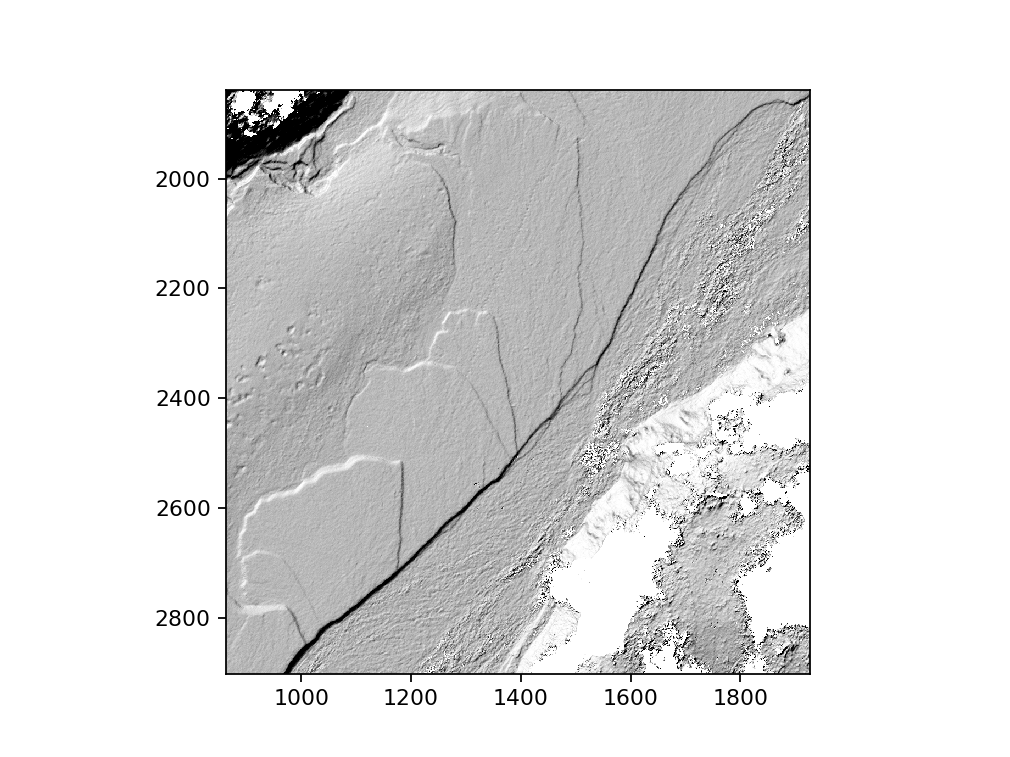

In [43]:
imgplot = plt.imshow(dem_hillshade, cmap='gray')

<IPython.core.display.Javascript object>


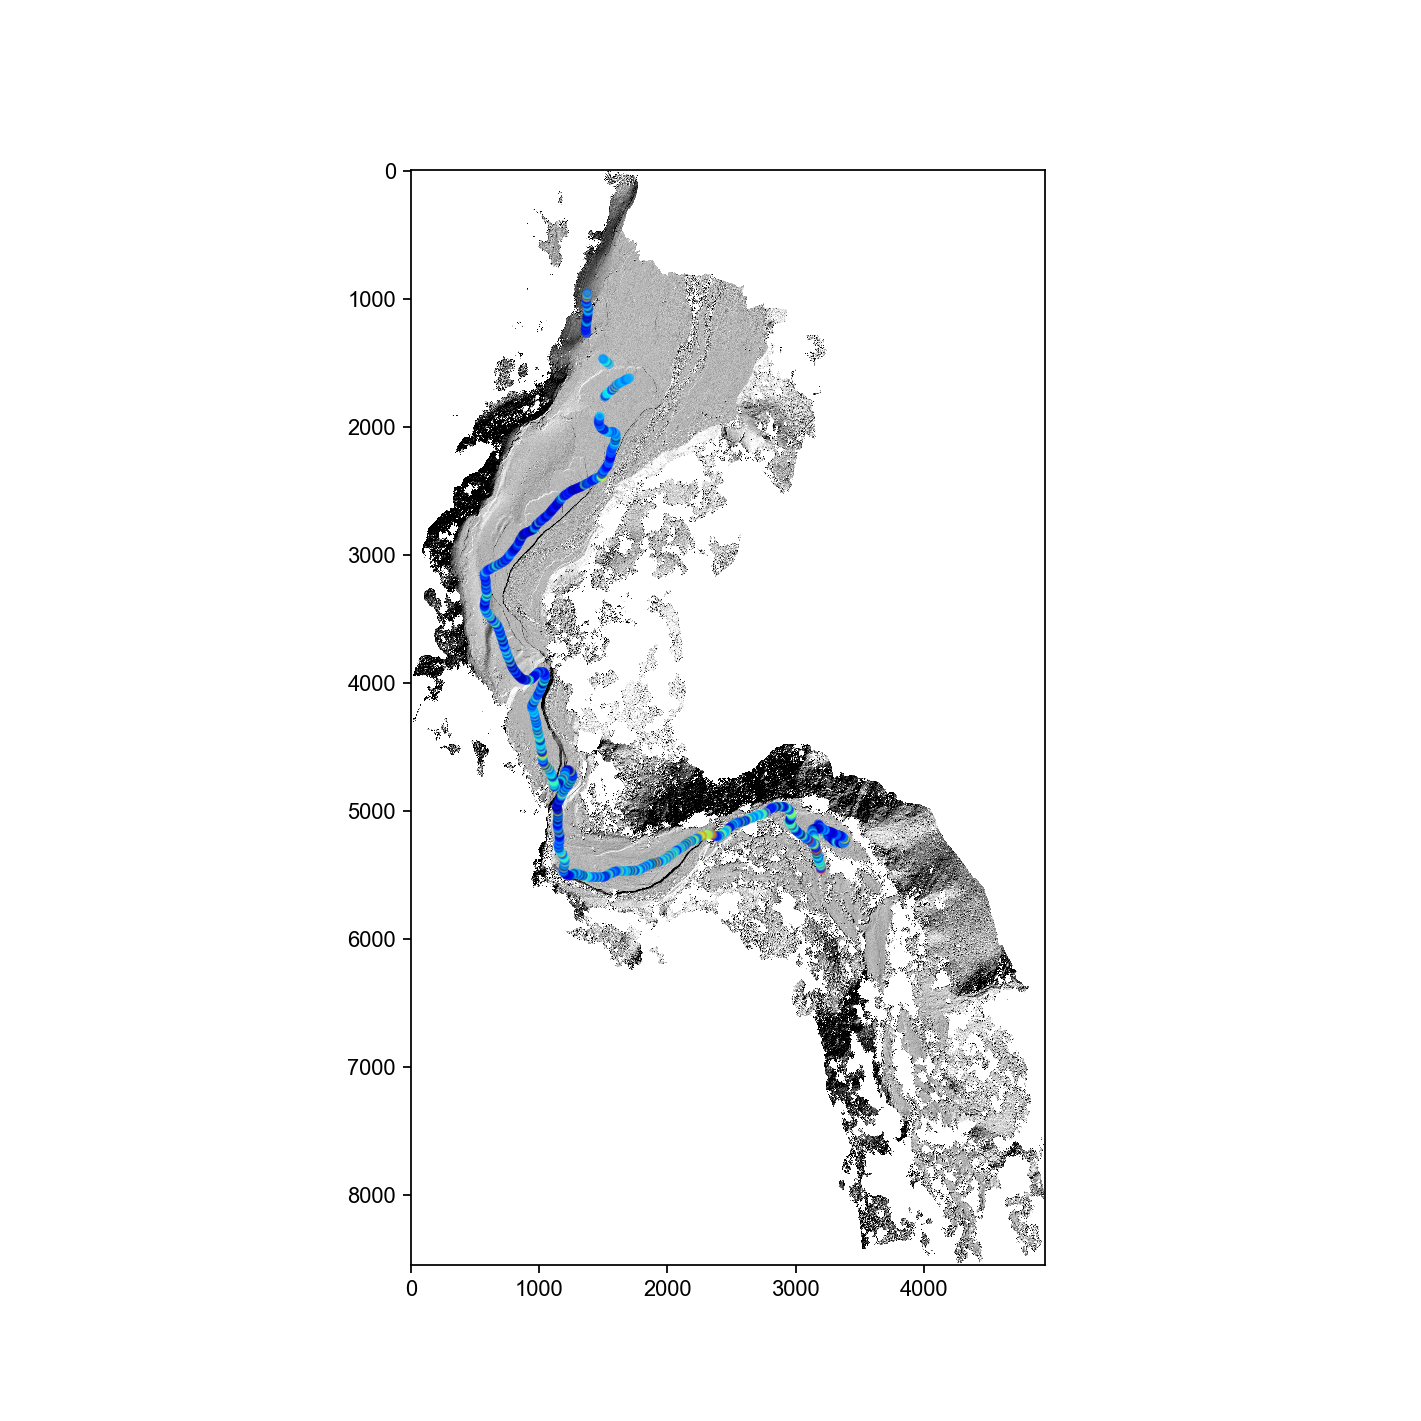

In [34]:
#on the fly hillshading
#from https://mtaplotlib.org/examples/specialty_plots/topographic_hillshading.html

from matplotlib.colors import LightSource
ls = LightSource(azdeg=315,altdeg=45)
fig=plt.figure(figsize=(9,9))
plt.imshow(ls.hillshade(dem, vert_exag=1.5, dx=0.1, dy=0.1), cmap='gray')

#plot points, using img coords, colors as abs(resid)
plt.scatter(x=df['demcol'], y=df['demrow'], c=df['resid'].abs(),cmap=plt.cm.jet, s=12,alpha=0.5)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


<IPython.core.display.Javascript object>


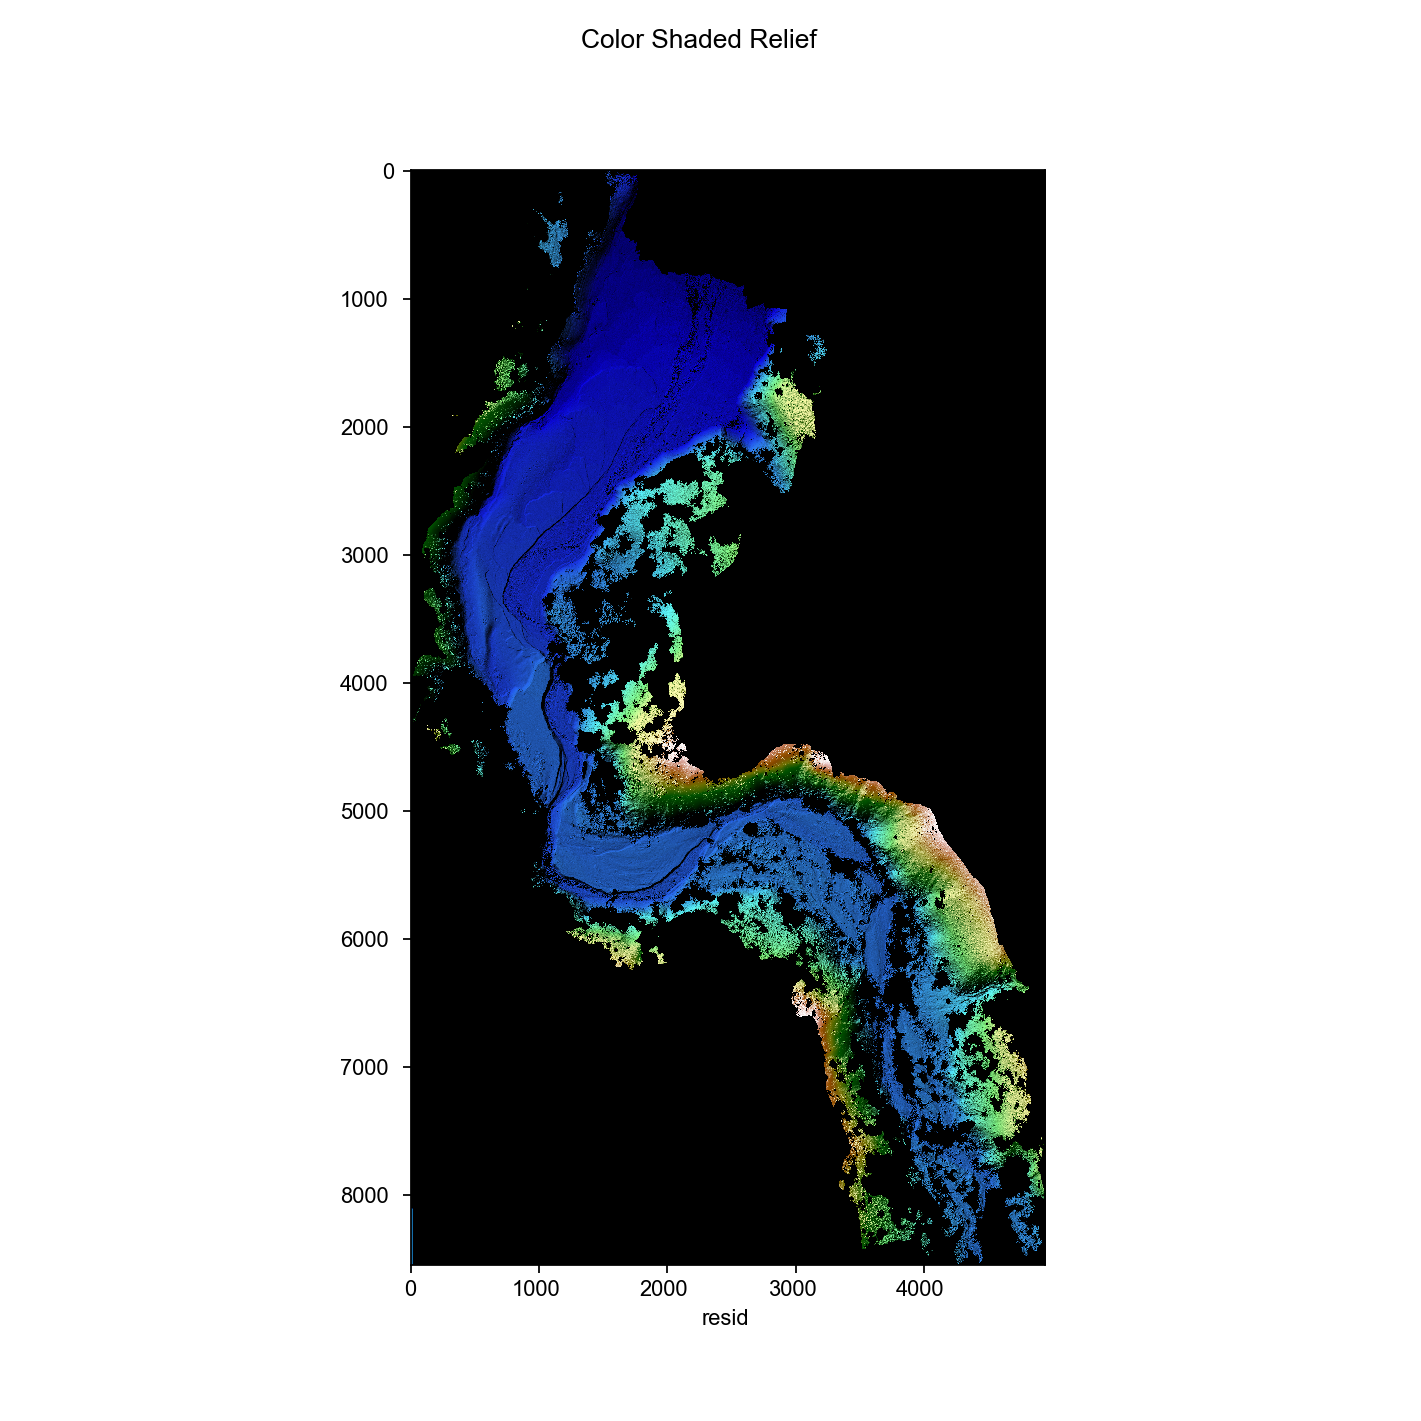

In [35]:
cmap = plt.cm.gist_earth
rgb = ls.shade(dem, cmap=cmap, blend_mode='overlay', vert_exag=2, dx=0.1, dy=0.1, vmin=np.nanmin(dem), vmax=np.nanmax(dem))
fig=plt.figure(figsize=(9,9))
plt.suptitle('Color Shaded Relief')
plt.imshow(rgb)


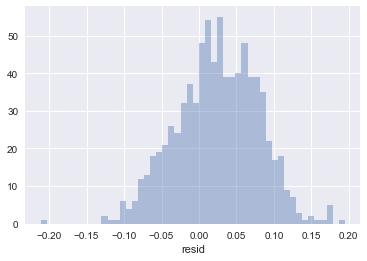

In [46]:
#plot histogram
%matplotlib inline
sns.set()
sns.set_context('notebook')
f=sns.distplot(df['resid'], bins=50, kde=False)
